In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import pandas as pd
import numpy as np
import os
import pickle
from matplotlib import pyplot as plt
%matplotlib inline 

In [2]:
NUM_EPOCH = 30
NUM_CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.001

In [3]:
data_file = 'data/sound_dataset_96_125_d2.pkl'
with open(data_file, 'rb') as f:
    dataset = pickle.load(f)

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=dataset[0],
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset[1],
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [9]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3, padding=1)
#         self.mp = nn.MaxPool2d(3)
        self.gap = nn.AvgPool2d(1)
        self.fc = nn.Linear(120000, 10)
        
    def forward(self, x):
        x = x.view(BATCH_SIZE, 1, 96, 125)
        in_size = x.size(0)
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = self.gap(x2)
        x4 = x3.view(in_size, -1)
        x5 = self.fc(x4)
        return F.log_softmax(x5)

In [13]:
# model = Net().double()
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
print(model)

Net(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AvgPool2d(kernel_size=1, stride=1, padding=0)
  (fc): Linear(in_features=120000, out_features=10, bias=True)
)


In [15]:
# Train the model
total_step = len(train_loader)
train_loss_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(NUM_EPOCH):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
#         images = images.to(device)
#         labels = labels.to(device)
        
        # Forward pass
#         outputs = model(images).double()
#         labels = labels.long()
        outputs = model(images)
        labels = labels.long()
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            train_loss_list.append(loss.item())
            print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, NUM_EPOCH, loss.item()))
#             model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
#             with torch.no_grad():
#                 correct = 0
#                 total = 0
#                 for images, labels in test_loader:
#                     images = images.to(device)
#                     labels = labels.to(device)
#                     outputs = model(images)
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 print('Test Accuracy of the model on the 250 test images: {} %'.format(100 * correct / total))
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
#         data, target = Variable(data, volatile=True), Variable(target)
#         data = data.to(device)
#         target = target.to(device)
        output = model(data).double()
        # sum up batch loss
        target = target.long()
        test_loss += F.nll_loss(output, target, size_average=False).data
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    test_loss_list.append(test_loss.item())
    test_accuracy_list.append((100. * correct / len(test_loader.dataset)).item())
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
#                    .format(epoch+1, NUM_EPOCH, i+1, total_step, loss.item()))


C:\Users\Hyde\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/30], Loss: 2.3092

Test set: Average loss: 8.0835, Accuracy: 20/200 (10%)

Epoch [2/30], Loss: 8.1500

Test set: Average loss: 3.7419, Accuracy: 20/200 (10%)

Epoch [3/30], Loss: 3.6003

Test set: Average loss: 2.6423, Accuracy: 20/200 (10%)

Epoch [4/30], Loss: 2.4539

Test set: Average loss: 2.3149, Accuracy: 40/200 (20%)

Epoch [5/30], Loss: 2.3229

Test set: Average loss: 2.0780, Accuracy: 122/200 (61%)

Epoch [6/30], Loss: 2.0496

Test set: Average loss: 1.7684, Accuracy: 134/200 (67%)

Epoch [7/30], Loss: 1.7164

Test set: Average loss: 1.3447, Accuracy: 179/200 (90%)

Epoch [8/30], Loss: 1.2390

Test set: Average loss: 0.8991, Accuracy: 196/200 (98%)

Epoch [9/30], Loss: 0.8614

Test set: Average loss: 0.4523, Accuracy: 200/200 (100%)

Epoch [10/30], Loss: 0.4082

Test set: Average loss: 0.1445, Accuracy: 200/200 (100%)

Epoch [11/30], Loss: 0.1024

Test set: Average loss: 0.0535, Accuracy: 200/200 (100%)

Epoch [12/30], Loss: 0.0316

Test set: Average loss: 0.0208, Acc

In [125]:
torch.save(model.state_dict(), 'CNN_GAP_dict.pkl')

In [56]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.numpy())

In [57]:
finalconv_name = 'conv2'
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.numpy())

model._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [58]:
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [59]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (96, 125)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [64]:
img = dataset[1][0]
img_arr = np.asarray([t.numpy() for t in img])
img = Variable(torch.from_numpy(img_arr[0])).view(1,1,96,125)

In [37]:
def get_features(pretrained_model, x, layers = [1,2]):
    net1 = nn.Sequential(*list(pretrained_model.children())[:layers[0]])
    out1 = net1(x) 
    net2 = nn.Sequential(*list(pretrained_model.children())[layers[0]:layers[1]])
    out2 = net2(out1)
    return out1, out2

In [67]:
img = dataset[1][1]
img_arr = np.asarray([t.numpy() for t in img])
img_arr[0].reshape(96,125)
img_batch = []

img = Variable(torch.from_numpy(img_arr[0])).view(1,1,96,125)

In [46]:
print(img.numpy())

[[[[0.5899052  0.54037422 0.50816834 ... 0.55428648 0.62497538
    0.65799767]
   [0.51848    0.47164476 0.43571937 ... 0.49950308 0.55004907
    0.5896666 ]
   [0.45796019 0.41686332 0.38865209 ... 0.46176374 0.5054543
    0.51728028]
   ...
   [0.43780676 0.42462468 0.38896725 ... 0.45048338 0.5450089
    0.60059994]
   [0.37074384 0.35216838 0.30637881 ... 0.35997689 0.4493261
    0.5128988 ]
   [0.3951329  0.36961636 0.32888487 ... 0.32443169 0.39828548
    0.4679656 ]]]]


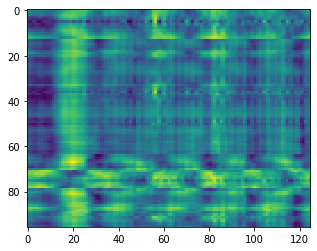

In [67]:
img_true = torch.squeeze(img,dim = 0)
# print(img_true)
img_true = img_true.numpy()
# print(img_true[0])
plt.imshow(img_true[0], interpolation='nearest')
plt.savefig('test.png')
plt.show()


In [38]:
output1,output2 = get_features(model,img)

In [39]:
print('output1.shape:',output1.shape)
print('output2.shape:',output2.shape)

output1.shape: torch.Size([1, 10, 96, 125])
output2.shape: torch.Size([1, 20, 96, 125])


In [53]:
output_1 = torch.squeeze(output1,dim = 0)
output_2 = torch.squeeze(output2,dim = 0)
print(output_1)

tensor([[[ 0.2617,  0.1542,  0.1353,  ...,  0.1958,  0.2292,  0.1769],
         [ 0.3111,  0.3603,  0.3267,  ...,  0.4121,  0.4496,  0.3074],
         [ 0.2175,  0.2642,  0.2450,  ...,  0.3419,  0.3797,  0.2343],
         ...,
         [ 0.2305,  0.2854,  0.2379,  ...,  0.3220,  0.4137,  0.3032],
         [ 0.2101,  0.2354,  0.1911,  ...,  0.2665,  0.3523,  0.2596],
         [ 0.0285,  0.1416,  0.1104,  ...,  0.1172,  0.1849,  0.1267]],

        [[ 0.2183, -0.2002, -0.1714,  ..., -0.1054, -0.1237, -0.3912],
         [ 0.1637, -0.2280, -0.2006,  ..., -0.1447, -0.1851, -0.3163],
         [ 0.1581, -0.1436, -0.0998,  ..., -0.1398, -0.1797, -0.2732],
         ...,
         [ 0.1480, -0.1725, -0.1761,  ..., -0.0623, -0.1035, -0.2873],
         [ 0.1000, -0.2098, -0.2077,  ..., -0.0707, -0.1047, -0.2524],
         [ 0.2066,  0.0605,  0.0499,  ...,  0.0940,  0.1084,  0.0583]],

        [[ 0.1824,  0.2051,  0.2086,  ...,  0.2056,  0.1940,  0.1428],
         [ 0.2486,  0.4153,  0.4037,  ...,  0

[[[ 0.26166973  0.15418422  0.13531206 ...  0.19575733  0.22923867
    0.17694441]
  [ 0.31108207  0.3603436   0.32670906 ...  0.41210794  0.44957842
    0.30741382]
  [ 0.21746526  0.26421049  0.24500543 ...  0.34192167  0.37968101
    0.23432374]
  ...
  [ 0.23052563  0.28539648  0.23788697 ...  0.3220341   0.41371405
    0.30320523]
  [ 0.21011268  0.23544054  0.19105186 ...  0.26648683  0.35229985
    0.25956656]
  [ 0.02852558  0.14157863  0.11040391 ...  0.11721208  0.18488225
    0.12674681]]

 [[ 0.21826896 -0.20024335 -0.1713893  ... -0.10535064 -0.12367579
   -0.39123882]
  [ 0.1636777  -0.22804721 -0.20060376 ... -0.14471528 -0.18511772
   -0.31626544]
  [ 0.15813793 -0.14355562 -0.09982748 ... -0.1398046  -0.17967339
   -0.27324351]
  ...
  [ 0.14796081 -0.17251806 -0.17610028 ... -0.06231754 -0.10346507
   -0.2872951 ]
  [ 0.10004271 -0.20975395 -0.20770411 ... -0.07067068 -0.10469706
   -0.25236305]
  [ 0.20656382  0.06047206  0.04992439 ...  0.09402873  0.10841002
    0.

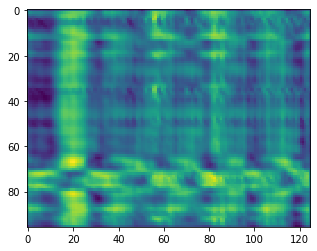

In [63]:
output_1_arr = output_1.data.numpy()
print(output_1_arr)
plt.imshow(output_1_arr[0], interpolation='nearest')
plt.show()

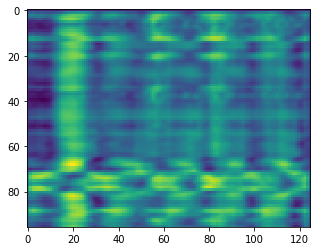

In [65]:
output_2_arr = output_2.data.numpy()
plt.imshow(output_2_arr[0], interpolation='nearest')
plt.show()